### Use CNN with PyTorch to learn CIFAR-10 (vgg16 model)

In [33]:
import torch 
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.autograd import Variable
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [34]:
# Hyper parameters
num_epochs = 100
hidden_sizes = [512]
input_channels = 3
num_classes = 10
batch_size = 100
learning_rate = 0.001

In [44]:
torch.cuda.is_available()

False

In [45]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

### Load CIFAR-10 dataset
Can be downloaded by `torchvision.datasets`

https://pytorch.org/docs/stable/torchvision/datasets.html

In [35]:
# CIFAR-10 dataset (32x32 colour images in 10 classes)
# https://www.cs.toronto.edu/~kriz/cifar.html
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train_dataset = torchvision.datasets.CIFAR10(root='dataset/',
                                           train=True, 
                                           transform=transform,
                                           download=True)

test_dataset = torchvision.datasets.CIFAR10(root='dataset/',
                                          train=False, 
                                          transform=transform,
                                          download=True)

Files already downloaded and verified
Files already downloaded and verified


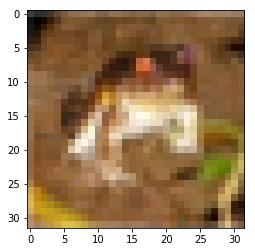

In [36]:
plt.imshow(train_dataset.train_data[0])

In [5]:
print('Original train size:', train_dataset.train_data.shape)
print(len(train_dataset.train_labels))
print('Original test size:', test_dataset.test_data.shape)
print(len(test_dataset.test_labels))

Original train size: (50000, 32, 32, 3)
50000
Original test size: (10000, 32, 32, 3)
10000


In [6]:
# # # 処理に時間のかかる場合はデータを削減
# small_num_train_dataset = 10000
# small_num_test_dataset = 5000

# train_dataset = [train_dataset[i] for i in range(small_num_train_dataset)]
# test_dataset = [test_dataset[i] for i in range(small_num_test_dataset)]

In [4]:
# Data loader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size, 
                                          shuffle=False)

### See data dimensions and show images

In [5]:
sample_train_data = iter(train_loader)
images, labels = sample_train_data.next()

In [6]:
print('After DataLoader')
print('Train dimensions:', images.shape)
print(len(labels))

After DataLoader
Train dimensions: torch.Size([100, 3, 32, 32])
100


In [57]:
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

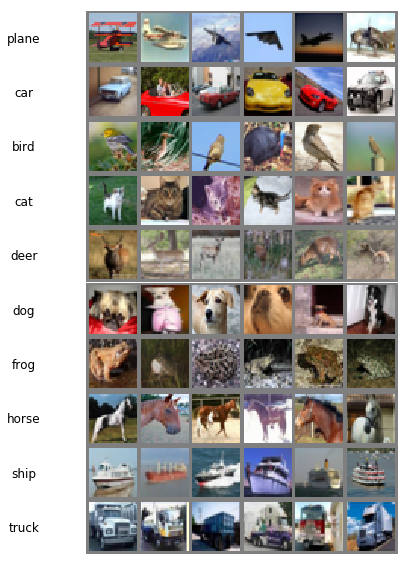

In [10]:
fig = plt.figure(figsize = (10, 10))
fig.subplots_adjust(hspace=0, wspace=0)
def show_photo(img, i, lname):
    img = img / 2 + 0.5
    npimg = img.numpy()
    ax = fig.add_subplot(10, 1, i, xticks=[], yticks=[])
    ax.imshow(np.transpose(npimg, (1, 2, 0)))
    ax.axis('off')
    ax.set_title(label=lname, x=-0.2, y=0.3)

for label, lname in enumerate(classes):
    target_label = (labels == label)
    imgs = images[target_label][:6] # Display 6 images
    show_photo(torchvision.utils.make_grid(imgs), label + 1, lname)

### Model vgg

Vgg16

```
Dimensions:
-> Input(32, 32) 
-> Conv (64, 32, 32) 
-> Conv (64, 32, 32) 
-> MaxPool (64, 16, 16)

-> Conv (128, 16, 16)
-> Conv (128, 16, 16) 
-> MaxPool (128, 8, 8)

-> Conv (256, 8, 8)
-> Conv (256, 8, 8)
-> Conv (256, 8, 8)
-> MaxPool (256, 4, 4)

-> Conv (512, 4, 4)
-> Conv (512, 4, 4) 
-> Conv (512, 4, 4)
-> MaxPool (512, 2, 2)

-> Conv (512, 2, 2)
-> Conv (512, 2, 2) 
-> Conv (512, 2, 2)
-> MaxPool (512, 1, 1)

-> Fully Connected Layer(Logits (10, 1) -> Softmax) -> Labels
```

### Build CNN model

Added dropout layer referring to http://torch.ch/blog/2015/07/30/cifar.html


In [37]:
class PytorchDeepConvNetVgg(nn.Module):
    def __init__(self, input_channels, num_classes=10):
        super(PytorchDeepConvNetVgg, self).__init__()

        # Layer 1: conv - relu - conv- relu - pool
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=input_channels, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))        
        
        # Layer 2: conv - relu - conv- relu - pool
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))

        # Layer 3: conv - relu - conv- relu - pool
        self.layer3 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))

        # Layer 4: conv - relu - conv- relu - pool
        self.layer4 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))

        # Layer 5: conv - relu - conv- relu - pool
        self.layer5 = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.5))


        # Fully Connected 1 (readout)
        # Affine - ReLU - Dropout - Affine - Dropout - Softmax
        self.layer6 = nn.Sequential(
            nn.Linear(512 * 1 * 1, hidden_sizes[0]),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(hidden_sizes[0], num_classes))

        # Initialize all parameters using kaiming normalization
        self.init_weights_kaiming()
    
    def init_weights_kaiming(self):
        #Use kaiming normalization to initialize the parameters
        for layer in [self.layer1, self.layer2, self.layer3, self.layer4, self.layer5, self.layer6]:
            for m in layer:
                if type(m) == nn.Conv2d or type(m) == nn.Linear:
                    m.weight = nn.init.kaiming_normal_(m.weight)

    def forward(self, x):

        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.layer5(out)
        
        out = out.view(out.size(0), -1)
    
        # Linear function (readout)
        out = self.layer6(out)
        
        return out

In [46]:
model = PytorchDeepConvNetVgg(input_channels, num_classes).to(device)
# print(model)

In [40]:
criterion = nn.CrossEntropyLoss()

In [24]:
#optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

# Use Adam as the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

### Learning rate decay schedule

In [42]:
# Decay after 25 epoch
exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=25, gamma=0.1)

### Load pretrained model parameters (if any)

In [ ]:
# load pretrained model trained with epoch 50 (pretrained by cuda version, so need to change map_location)
model.load_state_dict(torch.load('model_vgg.ckpt', map_location=lambda storage, loc: storage))

### Train model

In [16]:
# iter = 0
# accuracies = []
# for epoch in range(num_epochs):
    
#     # Learning rate decay
#     exp_lr_scheduler.step()

#     # Print current learning rate
#     if epoch % 25 == 0:
#         print(optimizer.param_groups[0]['lr'])

#     for i, (images, labels) in enumerate(train_loader):
        
#         # Load images as Variable
#         images = Variable(images).to(device)
#         labels = Variable(labels).to(device)
        
#         # Clear gradients w.r.t parameters
#         optimizer.zero_grad()
        
#         # Forward pass to get output/logits
#         outputs = model(images)
        
#         # Calculate Loss: Softmax --> cross entropy loss
#         loss = criterion(outputs, labels)
        
#         # Getting gradients w.r.t paramters
#         loss.backward()
        
#         # Updating parameters
#         optimizer.step()
        
#         iter += 1 

#         if iter % 500 == 0:
#             correct = 0
#             total = 0
#             model.eval()
#             with torch.no_grad():            
#                 for images, labels in test_loader:
#                     images = Variable(images).to(device)
#                     outputs = model(images)

#                     _, predicted = torch.max(outputs.data, 1)

#                     # Total numer of labels
#                     total += labels.size(0)

#                     correct += (predicted.to(device) == labels.to(device)).sum()

#                 accuracy = 100 * correct / total
#                 accuracies.append(accuracy)
        
#             # Print Loss
#             print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.data.item(), accuracy))

### Validate the model with test dataset

In [60]:
incorrect_predictions = []

model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = Variable(images)
        labels = Variable(labels)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        # See which are incorrect predictions
        result = (predicted == labels)
        err_imgs = images[result == 0] # 0 means incorrect prediction
        err_labels = labels[result == 0]
        err_outputs = predicted[result == 0]
        for img, lbl, out in zip(err_imgs, err_labels, err_outputs):
            incorrect_predictions.append((img, lbl, out))
     
    print('Test Accuracy of the model on the 10000 test images: {} %'.format(100 * correct / total))

Test Accuracy of the model on the 10000 test images: 83.66 %


In [73]:
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in train_loader:
        images = Variable(images).to(device)
        labels = Variable(labels).to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
    print('Test Accuracy of the model on the 50000 train images: {} %'.format(100 * correct / total))

Test Accuracy of the model on the 50000 train images: 99.742 %


### Visualize incorrect predictions

In [61]:
incorrect_pair = []
for p in incorrect_predictions:
    img, lbl, out = p
    incorrect_pair.append([lbl.item(), out.item()])

In [62]:
incorrect_df = pd.DataFrame(incorrect_pair, columns=['true', 'pred'])

In [63]:
true_to_classes = incorrect_df['true'].value_counts().to_frame()
true_to_classes = true_to_classes.sort_index()

In [64]:
pred_to_classes = incorrect_df['pred'].value_counts().to_frame()
pred_to_classes = pred_to_classes.sort_index()

In [65]:
#Paste the x_values code here
n = 1  # This is our first dataset (out of 2)
t = 2 # Number of datasets
d = 10 # Number of sets of bars
w = 0.8 # Width of each bar
true_x = [t*element + w*n for element
             in range(d)]

n = 2  # This is our second dataset (out of 2)
t = 2 # Number of datasets
d = 10 # Number of sets of bars
w = 0.8 # Width of each bar
pred_x = [t*element + w*n for element
             in range(d)]

In [66]:
yticks_label = [str(n) + ' ' +  str(i) for i, n in enumerate(classes)]
yticks_label

['plane 0',
 'car 1',
 'bird 2',
 'cat 3',
 'deer 4',
 'dog 5',
 'frog 6',
 'horse 7',
 'ship 8',
 'truck 9']

### Incorrect predictions breakdown:
- Got most incorrect predictions are the images with true label 'cat' and 'dog'.
- The most incorrect predicted answers are 'bird' then 'dog'.

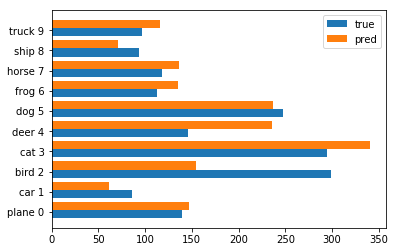

In [67]:
plt.barh(true_x, true_to_classes['true'])
plt.barh(pred_x, pred_to_classes['pred'])
plt.yticks(np.arange(1, 20, step=2), yticks_label)
plt.legend(('true', 'pred'))

### See top 10 incorrect prediction combinations

In [68]:
combination = incorrect_df.groupby(['true', 'pred']).size().reset_index().rename(columns={0:'count'})

In [69]:
combination = combination.sort_values('count', ascending=False)
combination.head(10)

,true,pred,count
44,5,3,143
29,3,5,115
19,2,4,72
18,2,3,59
28,3,4,56
20,2,5,54
17,2,0,47
16,1,9,45
75,9,1,44
65,8,0,42


In [70]:
top_incorrect = np.array(combination.iloc[:, 0:2][:10])

In [71]:
print('=== Top 10 incorrect predicted combinations ===')
print('(True) ---> (Predicted)')

for t, p in top_incorrect:
    print(' {:<5} ---> {:>5}'.format(classes[t],classes[p]))

=== Top 10 incorrect predicted combinations ===
(True) ---> (Predicted)
 dog   --->   cat
 cat   --->   dog
 bird  --->  deer
 bird  --->   cat
 cat   --->  deer
 bird  --->   dog
 bird  ---> plane
 car   ---> truck
 truck --->   car
 ship  ---> plane


### Test memo:

|model|dataset size(train/test)|#epoch|      model  |  optimizer | parameters |lr| accuracy(test/train) |
|-----|-----------------------|-------|--------------|------------|------------|--|------------|
|model 1|50000/10000|25|(conv - relu - conv- relu - pool)x2, lin |torch.optim.Adam|Kaiming He|0.001| 69.76/ 89.58%|
|model 2|50000/10000|25|(conv - relu - conv- relu - pool)x3, lin-relu-dropout-lin-dropout |torch.optim.Adam|Kaiming He|0.001| 70.83/ 96.01%|
|vgg16|50000/10000|25|vgg16 |torch.optim.Adam|Kaiming He|0.001| 81.01%/ 97.64%|
|vgg16|50000/10000|50|vgg16 |torch.optim.Adam|Kaiming He|0.001| 83.66%/ 99.74%|


### Save the model parameters after trained

In [20]:
# Save the model checkpoint
# torch.save(model.state_dict(), 'model.ckpt')

### Test with our own image

- rescale the input image http://scikit-image.org/docs/dev/auto_examples/transform/plot_rescale.html

/Users/ellenhe/anaconda/envs/py36/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


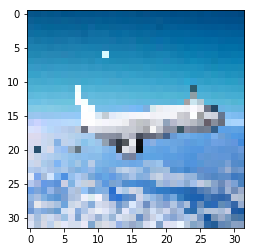

In [52]:
from skimage.transform import resize
num_px = 32
# my_image = "car.jpeg"   # change this to the name of your image file 
# my_image = "honda.jpeg"
# my_image = "sportcar.jpg"
# my_image = "gallardo.jpg"
my_image = 'plane.jpg'

# Preprocess the image to fit the algorithm.
fname = "image/" + my_image
image = np.array(plt.imread(fname))
my_image = resize(image,(num_px,num_px)).reshape(num_px, num_px, 3)

plt.imshow(my_image)

In [53]:
#https://stackoverflow.com/questions/49407303/runtimeerror-expected-object-of-type-torch-doubletensor-but-found-type-torch-fl
my_image = my_image.reshape(1, 3, num_px, num_px).astype('f4')

In [54]:
my_image = Variable(torch.from_numpy(my_image))

In [55]:
output = model(my_image).to(device)
_, predicted = torch.max(output.data, 1)

In [58]:
print('Prediction: ------label {}------ {}'.format(predicted.item(), classes[predicted.item()]))

Prediction: ------label 0------ plane
